In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta
from pykalman import KalmanFilter

from performance.performance_metrics import percentage_returns, sharpe_ratio
from performance.risk_free_rate import compute_risk_free_rate

In [2]:
today = date.today()

end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=300)).strftime("%Y-%m-%d")

start_date, end_date

('2022-01-01', '2022-10-28')

In [3]:
# S&P500: price index (non-tradable) = GSPC; option index = SPX; ETF = SPY.
ticker = "SPY"  # S&P500
interval = "1h"

# Easier to rename
price = "price"

df_raw = yf.download(ticker, start=start_date, end=end_date, interval=interval)

df = df_raw.drop(columns=["Open", "High", "Low", "Close", "Volume"])
df.rename(columns={"Adj Close": price}, inplace=True)
df.tail(2)

[*********************100%***********************]  1 of 1 completed


,price
2022-10-27 15:30:00-04:00,379.970001
2022-10-27 16:00:00-04:00,379.980011


In [4]:
# Initalise state s0 with: (mean, covariance) = normal(0, 1)
kf = KalmanFilter(
    transition_matrices=[1.0],
    observation_matrices=[1.0],
    initial_state_mean=0.0,
    initial_state_covariance = 1.0,
    observation_covariance=1.0,
    transition_covariance=0.01,
)

state_means, _ = kf.filter(df[price])

df["Kalman Filter"] = state_means

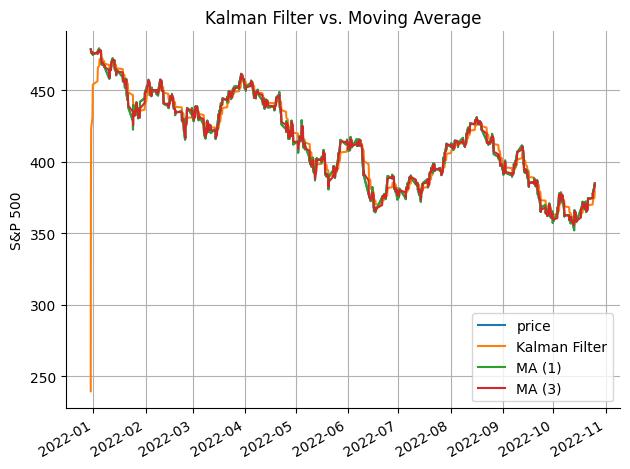

In [5]:
# Create moving averages to compare to.
for time_step in [1, 3]:
    df[f"MA ({time_step})"] = df[price].rolling(window=time_step).mean()

    
ax = df.plot(title='Kalman Filter vs. Moving Average') #, figsize=(14,6), lw=1, rot=0)
ax.set_ylabel("S&P 500")
plt.grid()
plt.tight_layout()
sns.despine()

In [6]:
df = df \
    .pipe(percentage_returns, price_colname=price, output_colname="returns") \
    .pipe(compute_risk_free_rate, method="constant", constant=0.0, output_colname="risk_free_returns") \
    .pipe(sharpe_ratio, returns_colname="returns", risk_free_returns_colname="risk_free_returns", output_colname="sharpe_ratio") \
    .dropna()  # No inplace - pipe.

df.tail(2)

,price,Kalman Filter,MA (1),MA (3),returns,risk_free_returns,sharpe_ratio
2022-10-25 14:30:00-04:00,384.755005,378.208091,384.755005,383.921672,0.001888,0.0,-0.024469
2022-10-25 15:30:00-04:00,384.890015,378.843708,384.890015,384.558339,0.000351,0.0,-0.024416


In [7]:
df["directional_returns"] = df.apply(lambda row: 0 if row["returns"] < 0 else 1, axis=1)
df.tail(2)

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3231/604813132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["directional_returns"] = df.apply(lambda row: 0 if row["returns"] < 0 else 1, axis=1)


,price,Kalman Filter,MA (1),MA (3),returns,risk_free_returns,sharpe_ratio,directional_returns
2022-10-25 14:30:00-04:00,384.755005,378.208091,384.755005,383.921672,0.001888,0.0,-0.024469,1
2022-10-25 15:30:00-04:00,384.890015,378.843708,384.890015,384.558339,0.000351,0.0,-0.024416,1


In [8]:
df["returns_tp1"] = df["returns"].shift(-1)
df.dropna(inplace=True)

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3231/3967636402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns_tp1"] = df["returns"].shift(-1)
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3231/3967636402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


# Sanity Check
1. Assess whether the past Kalman-Filtered returns correlate to one-period ahead returns and direction of one-period ahead returns better than simple moving-averages.
2. Benchmark against raw (noisy) past returns as predictors (t vs. tp1).

In [9]:
# Number of rows to drop
warmup_periods = 15

# Drop the warm-up period of the Kalman Filter
correlation_df = df.iloc[warmup_periods:].corr()

In [10]:
keep_rows = ["returns", "directional_returns", "sharpe_ratio", "returns_tp1"]
keep_columns = ["Kalman Filter", "MA (1)", "MA (3)"] + keep_rows

correlation_df.loc[keep_rows][keep_columns] \
    .style.background_gradient(cmap="coolwarm", axis=None, vmin=-1, vmax=1) \
    .highlight_null(null_color='#f1f1f1') \
    .set_precision(2)

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3231/1681763082.py:4: FutureWarning: `null_color` is deprecated: use `color` instead
  correlation_df.loc[keep_rows][keep_columns] \
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3231/1681763082.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_df.loc[keep_rows][keep_columns] \


,Kalman Filter,MA (1),MA (3),returns,directional_returns,sharpe_ratio,returns_tp1
returns,-0.05,0.02,-0.03,1.00,0.69,0.07,0.02
directional_returns,-0.07,-0.01,-0.04,0.69,1.00,0.08,0.02
sharpe_ratio,-0.43,-0.38,-0.39,0.07,0.08,1.00,-0.00
returns_tp1,-0.05,-0.05,-0.05,0.02,0.02,-0.00,1.00
